# Process

Tăng số lượng ảnh lên $3$ lần  với các phép xoay, lật, tăng sáng, thêm nhiễu muối, biến đổi affine...

In [ ]:
import os
import cv2
import albumentations as A
from tqdm import tqdm

# Đường dẫn
input_dir = "data/Data"
output_dir = "data/Data_x3"
os.makedirs(output_dir, exist_ok=True)

# # Pipeline tăng cường
# augmentations = [
#     A.Compose([A.HorizontalFlip(p=1), A.RandomBrightnessContrast(p=1)]),
#     A.Compose([
#         A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=1),
#         A.OneOf([
#                 A.MultiplicativeNoise(multiplier=(0.95, 1.05), p=0.5),
#                 A.MotionBlur(p=0.3),
#                 A.ImageCompression(quality_lower=80, quality_upper=100, p=0.3),
#             ], 
#             p=0.7
#         )
#     ]),
#     A.Compose([A.RandomBrightnessContrast(p=0.5), A.HorizontalFlip(p=0.5)])
# ]
augmentations = [
    A.Compose([
        A.HorizontalFlip(p=1),
        A.RandomBrightnessContrast(p=0.5)
    ]),
    A.Compose([
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=1),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.5)
    ]),
    A.Compose([
        A.RandomBrightnessContrast(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.MultiplicativeNoise(multiplier=(0.95, 1.05), p=0.3)
    ])
]


# Duyệt qua từng classes
for c in os.listdir(input_dir):
    os.makedirs(f'{output_dir}/{c}', exist_ok=True)
    # Duyệt qua từng ảnh
    for fname in tqdm(os.listdir(f'{input_dir}/{c}'), ncols=100, colour="green", desc=c):
        if fname.endswith((".png", ".jpg", ".jpeg")):
            img = cv2.imread(os.path.join(f'{input_dir}/{c}', fname))
            base = os.path.splitext(fname)[0]

            # Lưu ảnh gốc
            cv2.imwrite(os.path.join(f'{output_dir}/{c}', f"{base}_orig.png"), img)

            # Tạo và lưu augment
            for i, aug in enumerate(augmentations):
                aug_img = aug(image=img)["image"]
                cv2.imwrite(os.path.join(f'{output_dir}/{c}', f"{base}_aug{i+1}.png"), aug_img)


/tmp/ipykernel_2253115/1407834147.py:33: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.5)
osteopenia: 100%|█████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.09it/s]


# Enhance

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tools.process import adjust_gamma, adjust_exposure, clahe, sharpen, is_blurry, unsharp_mask


In [11]:
def blurry_process(image_rgb):
    # Kiểm tra độ mờ
    blurry, score = is_blurry(image_rgb, threshold=1000)
    # Nếu mờ, áp dụng khử mờ bằng unsharp mask
    if blurry:
        image_rgb = unsharp_mask(image_rgb)
    return image_rgb, score

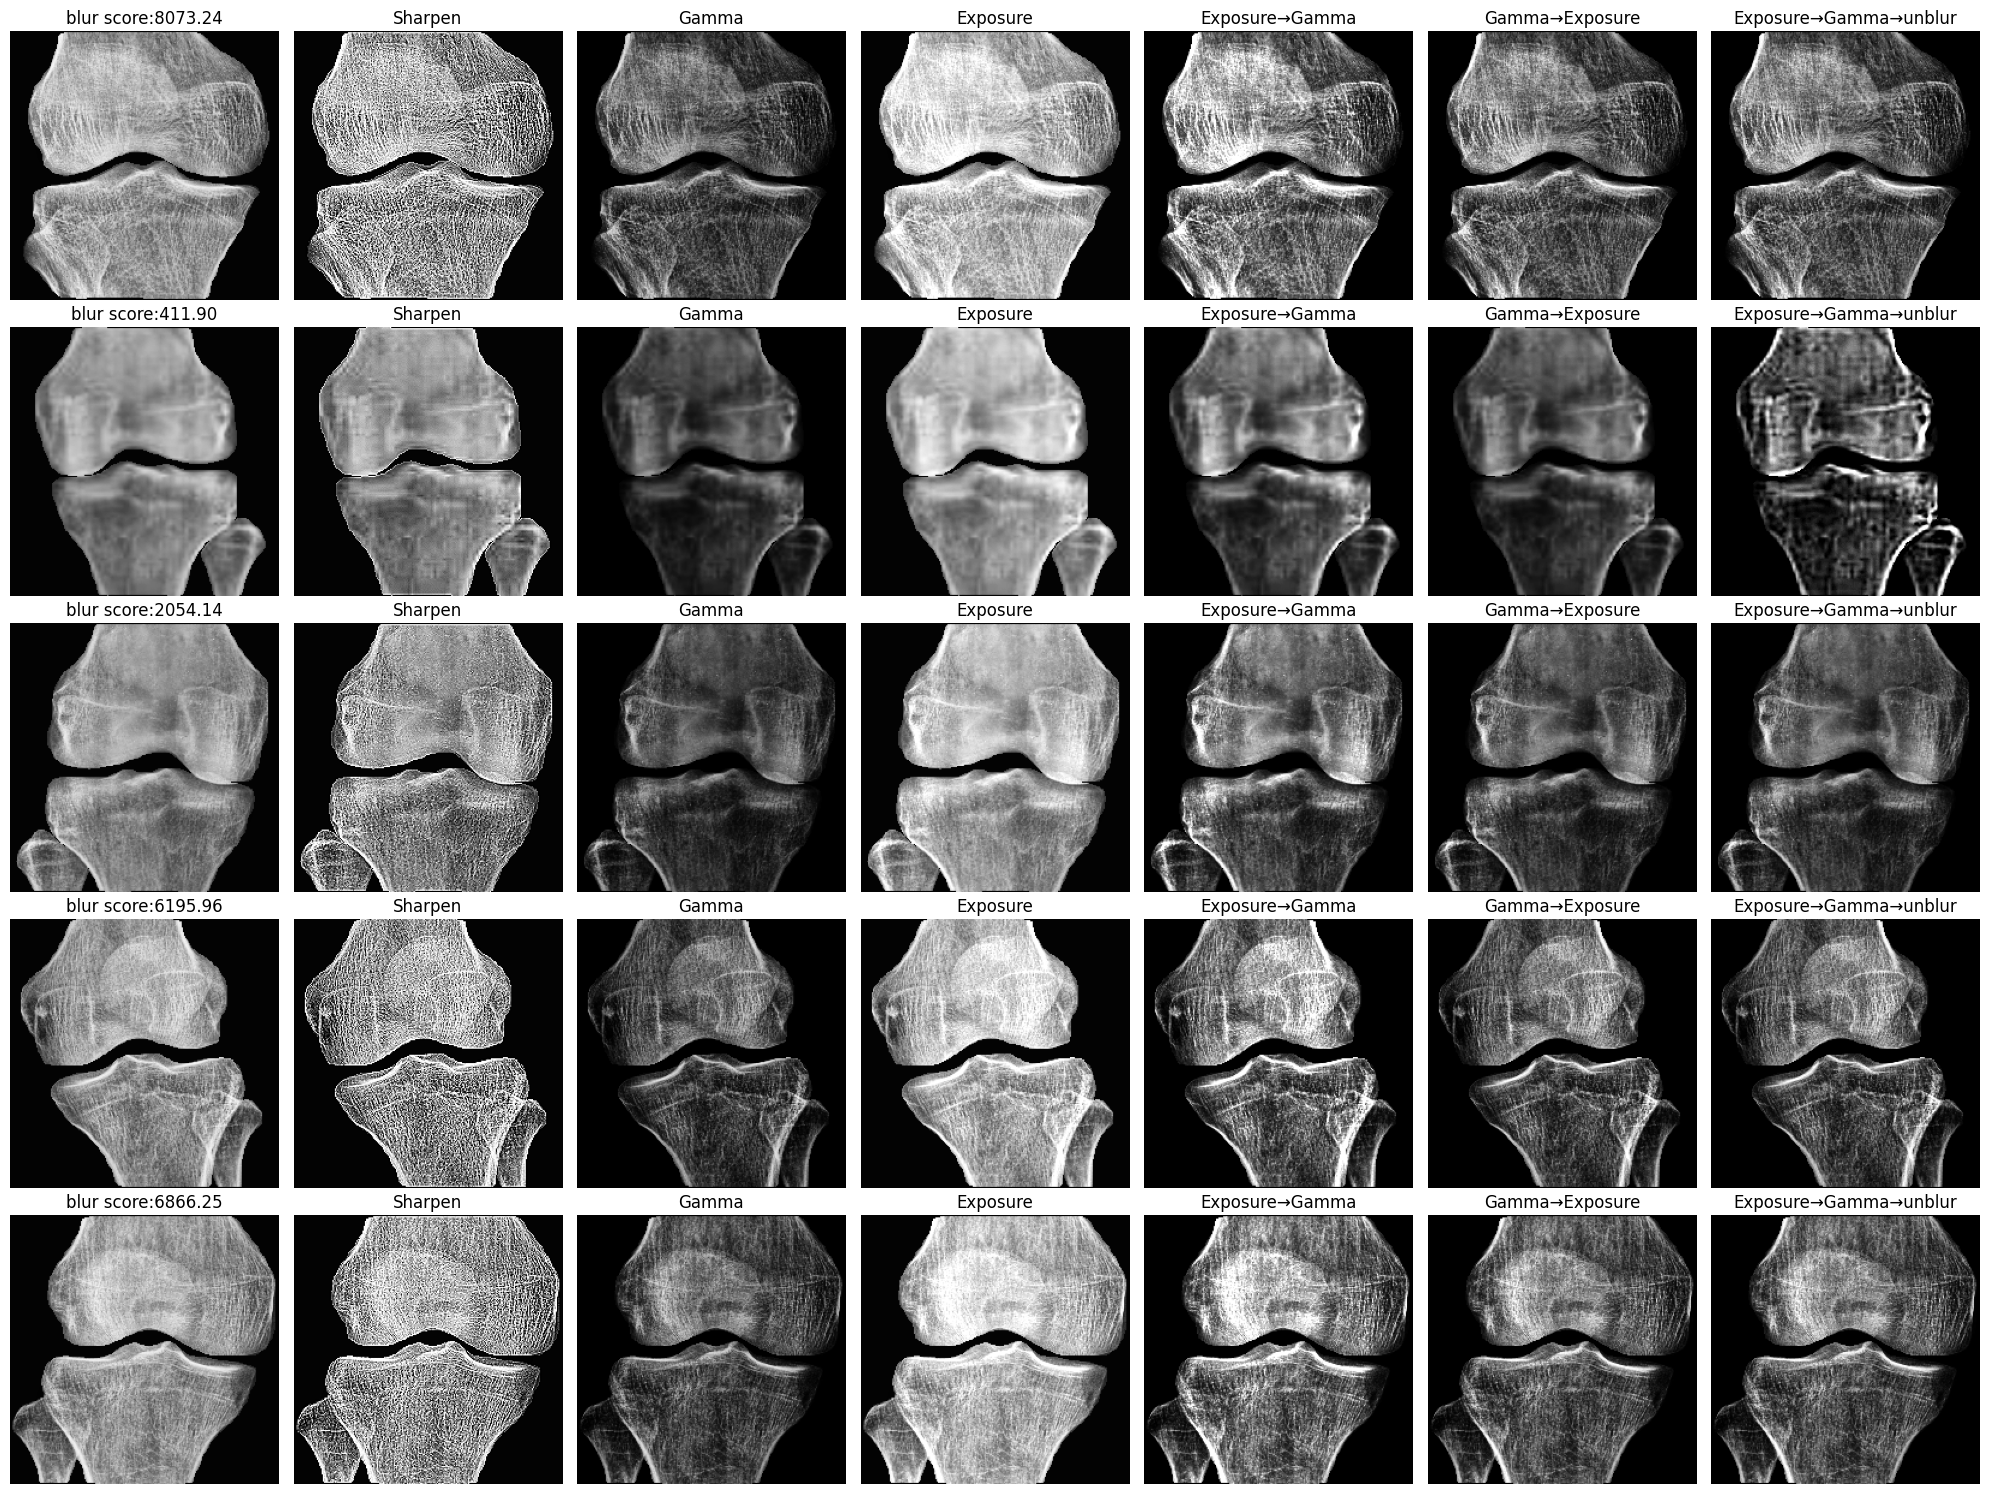

In [ ]:
data_path = "data/Data_x3_seg/osteoporosis"
image_paths = os.listdir(data_path)[:5]
fig, axs = plt.subplots(len(image_paths), 7, figsize=(20, 3 * len(image_paths)))

for i, path in enumerate(image_paths):
    image_path = os.path.join(data_path, path)
    image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_gray = cv2.resize(image_gray, (224, 224))
    image_rgb = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)

    image_rgb = clahe(image_rgb)

    # Các phép biến đổi
    img_gamma = adjust_gamma(image_rgb, gamma=0.4)
    img_exposure = adjust_exposure(image_rgb, factor=1.2)
    img_sharp = sharpen(image_rgb)
    img_exposure_gamma = adjust_gamma(adjust_exposure(image_rgb, factor=1.2), gamma=0.4)
    img_gamma_exposure = adjust_exposure(adjust_gamma(image_rgb, gamma=0.4), factor=1.2)
    image_unblur, score = blurry_process(img_gamma_exposure)  # Sửa ở đây

    # Hiển thị
    axs[i, 0].imshow(image_rgb)
    axs[i, 0].set_title(f"blur score:{score:.2f}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(img_sharp)
    axs[i, 1].set_title("Sharpen")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(img_gamma)
    axs[i, 2].set_title("Gamma")
    axs[i, 2].axis('off')

    axs[i, 3].imshow(img_exposure)
    axs[i, 3].set_title("Exposure")
    axs[i, 3].axis('off')

    axs[i, 4].imshow(img_exposure_gamma)
    axs[i, 4].set_title("Exposure→Gamma")
    axs[i, 4].axis('off')

    axs[i, 5].imshow(img_gamma_exposure)
    axs[i, 5].set_title("Gamma→Exposure")
    axs[i, 5].axis('off')

    axs[i, 6].imshow(image_unblur)
    axs[i, 6].set_title("Exposure→Gamma→unblur")
    axs[i, 6].axis('off')

plt.tight_layout()
plt.show()

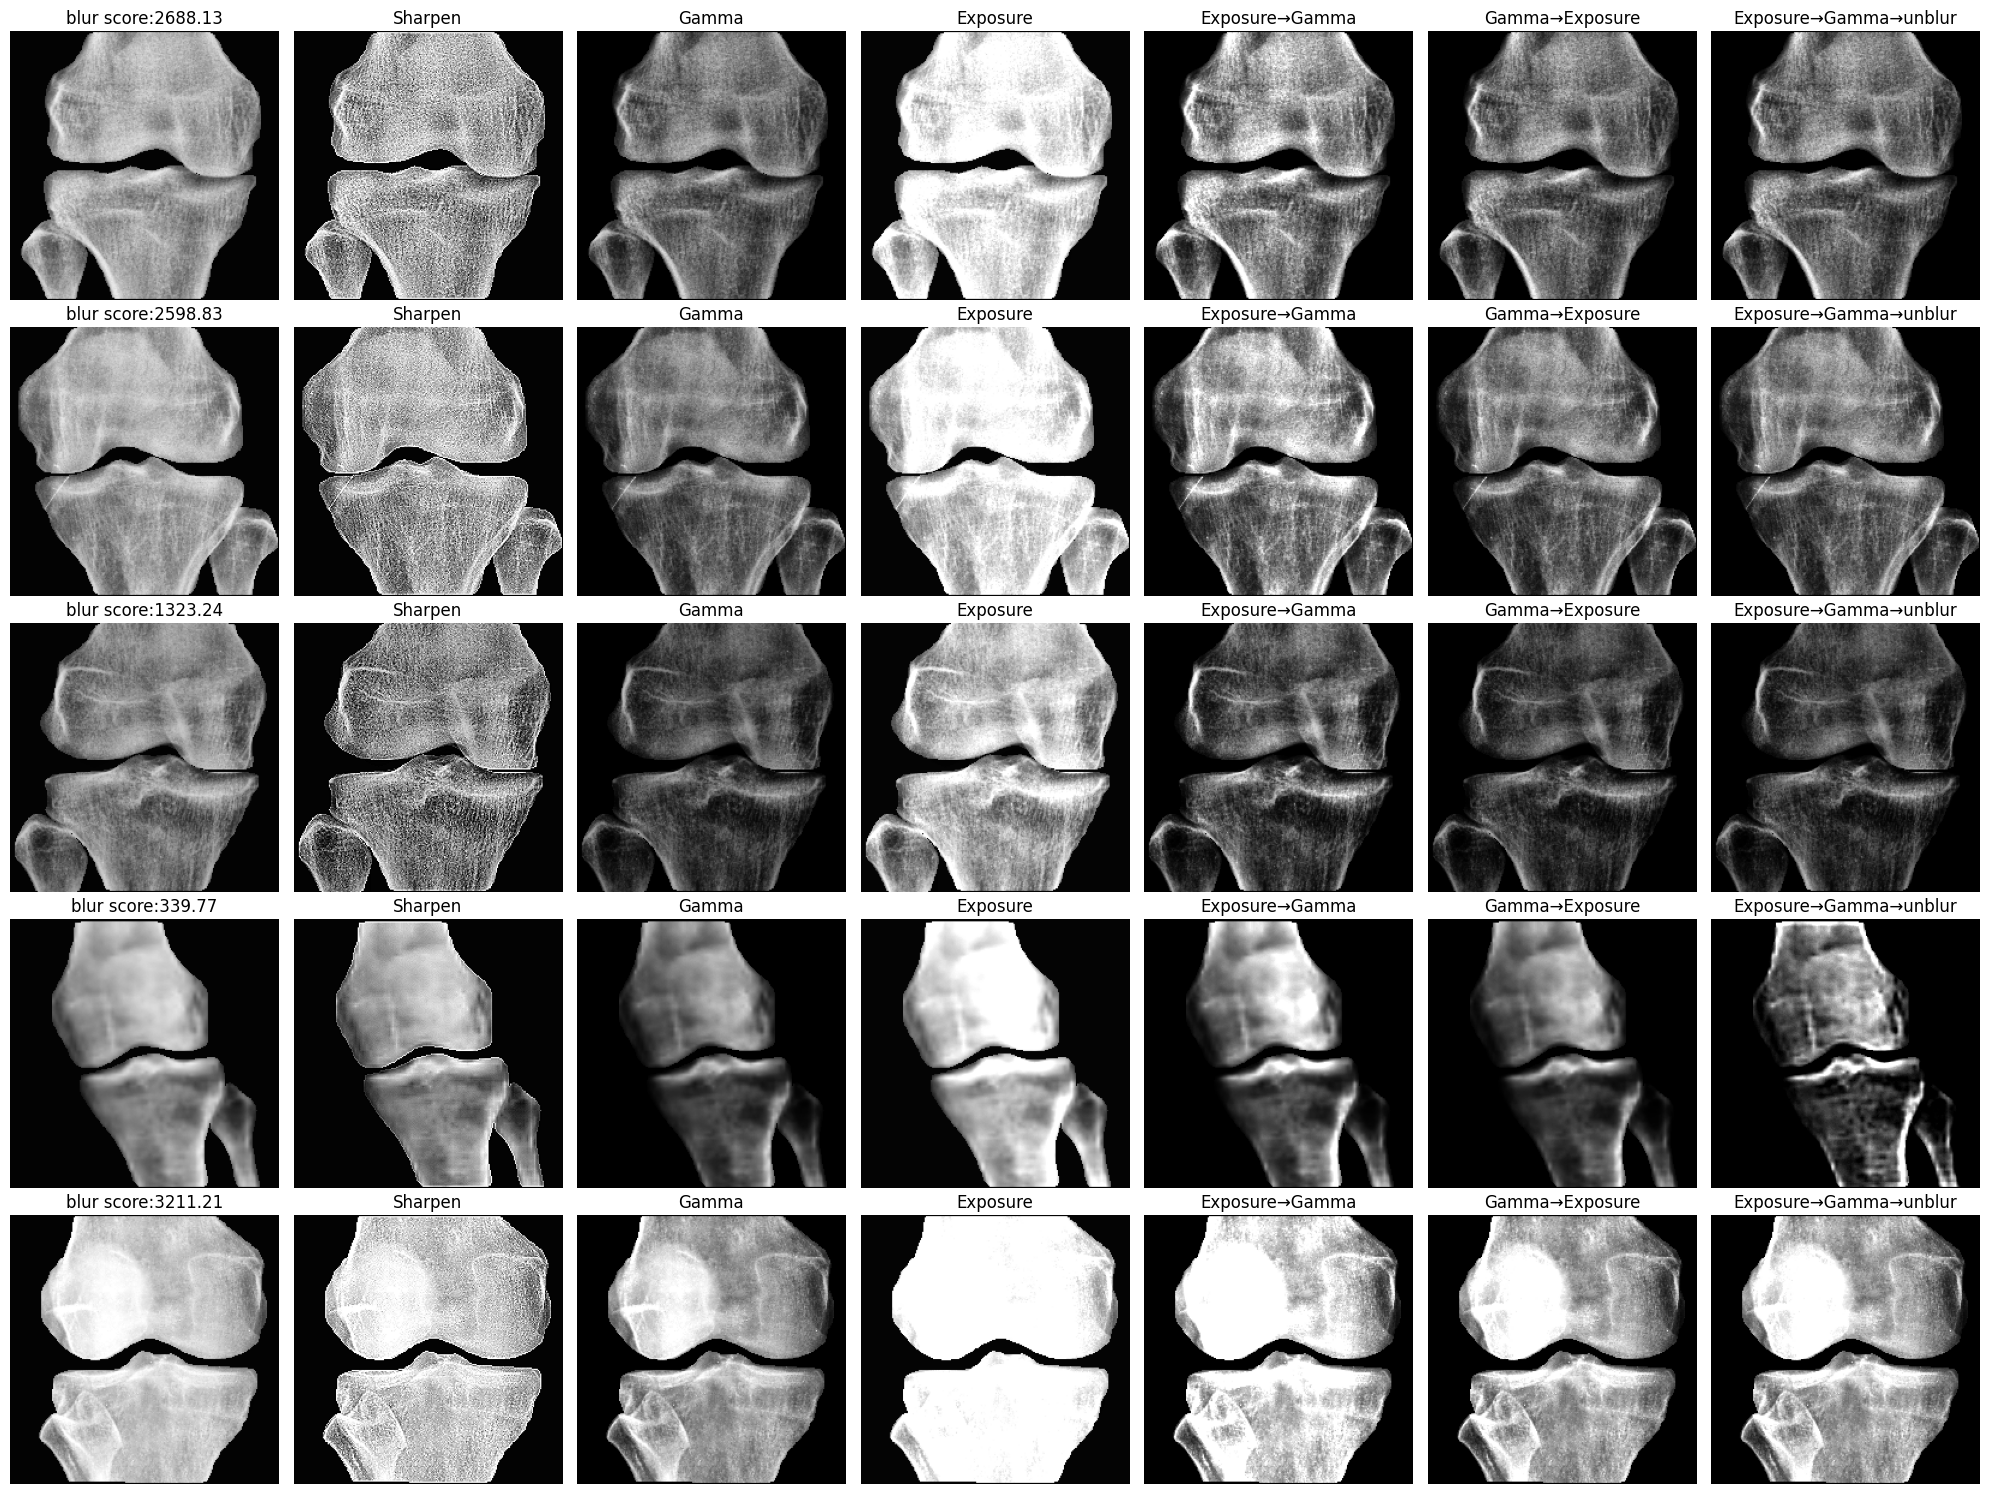

In [25]:
data_path = "data/Data_x3_seg/normal"
image_paths = os.listdir(data_path)[:4] + ["9_aug1_roi1.png"]
fig, axs = plt.subplots(len(image_paths), 7, figsize=(20, 3 * len(image_paths)))

for i, path in enumerate(image_paths):
    image_path = os.path.join(data_path, path)
    image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_gray = cv2.resize(image_gray, (224, 224))
    image_rgb = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)

    image_rgb = clahe(image_rgb)

    # Các phép biến đổi
    img_gamma = adjust_gamma(image_rgb, gamma=0.5)
    img_exposure = adjust_exposure(image_rgb, factor=1.4)
    img_sharp = sharpen(image_rgb)
    img_gamma_exposure = adjust_exposure(adjust_gamma(image_rgb, gamma=0.4), factor=1.2)
    img_exposure_gamma = adjust_gamma(adjust_exposure(image_rgb, factor=1.2), gamma=0.4)
    image_unblur, score = blurry_process(img_gamma_exposure)  # Sửa ở đây

    # Hiển thị
    axs[i, 0].imshow(image_rgb)
    axs[i, 0].set_title(f"blur score:{score:.2f}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(img_sharp)
    axs[i, 1].set_title("Sharpen")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(img_gamma)
    axs[i, 2].set_title("Gamma")
    axs[i, 2].axis('off')

    axs[i, 3].imshow(img_exposure)
    axs[i, 3].set_title("Exposure")
    axs[i, 3].axis('off')

    axs[i, 4].imshow(img_exposure_gamma)
    axs[i, 4].set_title("Exposure→Gamma")
    axs[i, 4].axis('off')

    axs[i, 5].imshow(img_gamma_exposure)
    axs[i, 5].set_title("Gamma→Exposure")
    axs[i, 5].axis('off')

    axs[i, 6].imshow(image_unblur)
    axs[i, 6].set_title("Exposure→Gamma→unblur")
    axs[i, 6].axis('off')

plt.tight_layout()
plt.show()

In [26]:
from tqdm import tqdm

# Đường dẫn gốc và đầu ra
input_root = "data/Data_x3_seg"
output_root = "data/Data_x3_seg_enhance"
os.makedirs(output_root, exist_ok=True)

# Duyệt 2 class: normal, osteoporosis
for label in os.listdir(input_root):
    input_class_dir = os.path.join(input_root, label)
    output_class_dir = os.path.join(output_root, label)
    os.makedirs(output_class_dir, exist_ok=True)

    # Duyệt từng ảnh trong class
    for fname in tqdm(os.listdir(input_class_dir), desc=f"Processing {label}", ncols=100, colour="green"):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(input_class_dir, fname)
            image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # image_gray = cv2.resize(image_gray, (224, 224))
            image_rgb = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)

            image_rgb = clahe(image_rgb)

            # Các phép biến đổi
            img_gamma_exposure = adjust_exposure(adjust_gamma(image_rgb, gamma=0.4), factor=1.2)
            image_unblur, score = blurry_process(img_gamma_exposure)  # Sửa ở đây

            # Lưu kết quả
            save_path = os.path.join(output_class_dir, fname)
            cv2.imwrite(save_path, image_unblur)


Processing osteoporosis: 100%|█████████████████████████████████| 3308/3308 [00:06<00:00, 514.64it/s]
